In [1]:
%%capture
!git clone https://github.com/chrimerss/GIS-Hydrology-workshop.git

# Remote sensing/GIS in Hydrology

Materials prepared by Zhi Li

Update date: 05/17/2024

About me:

<img src="https://github.com/chrimerss/GIS-Hydrology-workshop/blob/main/resource/AboutMe.png?raw=true">

Contact: li1995@stanford.edu

X: @chrimersslee

Linkedin: https://www.linkedin.com/in/zhi-li-a79116167/

# Logistics

We have a small-sized focused group, so I will try to make it engaging and interactive.

Feel free to ask any questions or clarifications during the workshop. Hope you can get something useful out of this workshop.

Stay with your pace, no peer pressure :)




# Outline of this two-day workshop

Day 1 (May 17, 4-7 PM):

1. Brief intro to the water cycle (~10 mins)
2. Remote sensing-based precipitation products (~120 mins)
    - Overview of existing gridded precipitation products (~30 mins)
    - __Hands-on:__ Comparison of satellite-based precipitation and radar-based quantitative precipitation estimation (QPE) (~60 mins)
    - __Exercise:__ Modify the dates and region of your interest to animate precipitation propagation during a rainfall event. (~ 20 mins)
    - __Presentation:__ Share your results and explain why you're interested in this weather event. (~10 mins)
3. Feedback or discussions (30 mins)



Day 2 (May 19, 10 AM - 1 PM):

1. Brief intro to hydrological modeling (~20 mins)
2. Hands on tutorial - simulating streamflow using a lumped hydrologic model (~60 mins)
3. Competition - traditional physical approach vs. AI (~60 mins)
4. Reflection and conclusion (~ 30mins)

# The Water Cycle

We always start with Water cycle:

![image](https://i0.wp.com/eos.org/wp-content/uploads/2022/10/usgs-water-cycle.png?ssl=1)

![image](https://www.worldatlas.com/r/w1200/upload/b7/e8/4a/transpiration.png)


# Precipitation

Argubly, precipitation is one of the most important components in water cycle. It provides essential water for sustaining life on Earth. On the other side, too much or too little precipitation can be detrimental. Therefore, quantifying the amount of precipitation is critical. How do we measure precipitation?

<img width="150%" src="https://github.com/chrimerss/GIS-Hydrology-workshop/blob/main/resource/imergert_1080p_30-ezgif.com-video-to-gif-converter.gif?raw=true">


## In-situ rain gauges

Commonly used rainfall measuring device is tipping bucket rain gauge:

<img width="200%" src="https://www.weathershack.com/images/tipping-bucket-rain-gauge.gif">



However, certain limitations exist:

1. Overflow in extreme rainfall conditions
2. Wind undercatch
3. Filled by other objects (e.g., bird feces)
4. Point estimates

<img src="https://www.researchgate.net/publication/200472090/figure/fig1/AS:305847918972928@1449931234014/b-Global-distribution-of-in-situ-rainfall-gauges-showing-the-sparse-and-unevenness-in.png">

<img src="https://github.com/chrimerss/GIS-Hydrology-workshop/blob/main/resource/gauge_products.png?raw=true">

(Sun et al., 2018)

## Ground-based weather radar

Since WW-II, radar has been used for weather monitoring, especially for severe weather.

<img src="https://www.weather.gov/images/mlb/radar/image003.gif">

Over the CONUS, there are about 140 weather radar stations, and their coverage is shown below.

<img src="https://www.researchgate.net/publication/340622985/figure/fig1/AS:953252203991041@1604284444474/MRMS-radar-quality-index-The-quality-index-considers-the-distance-to-the-closest-radar.jpg">

Limitations:

1. Blockage over mountainous regions
2. Less accurate than rain gauge estimates
3. interfered by non-meteorological features



## Satellite Precipitation

Only satellite can provide an unprohibited view of precipitation in complex terrains with its top-down scan.

<img src="https://www.researchgate.net/publication/345000747/figure/fig1/AS:952273580609540@1604051122919/The-Global-Precipitation-Measurements-GPM-constellation-includes-US-and-international.png">

In [2]:
from ipywidgets import Video
Video.from_file("/content/GIS-Hydrology-workshop/resource/GPM_DPR_first-light_final.webmhd.webm", width=640, height=400)

Video(value=b'\x1aE\xdf\xa3\x01\x00\x00\x00\x00\x00\x00\x1fB\x86\x81\x01B\xf7\x81\x01B\xf2\x81\x04B\xf3\x81\x0…

A table of satellite precipitation products

<img src="https://github.com/chrimerss/GIS-Hydrology-workshop/blob/main/resource/satellite_products.png?raw=true">

(Sun et al., 2018)

Precipitation product availability:

<img src="https://github.com/chrimerss/GIS-Hydrology-workshop/blob/main/resource/product_availability.png?raw=true">

# Know your local weather

About 50% of the California rainfall is delivered by Atmospheric Rivers (ARs). So, what is Atmospheric River?

Atmospheric River is a relatively narrow region of intense vertically integrated water vapor transport

    - >= 2000 km length

    - 400-600 km width

    - >20 mm integrated water vapor (precipitable water)

    - >= 250 kg/m/s integrated vapor transport (IVT)


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/The_science_behind_atmospheric_rivers.jpg/2560px-The_science_behind_atmospheric_rivers.jpg">


<img src="https://helios-i.mashable.com/imagery/articles/02gIsv5a4aDaKeWplMQIv1V/images-1.fill.size_2000x817.v1619015134.gif">



# Hands-on tutorial

Now, we can get our hands dirty with some case studies. We will start with acquiring precipitation data from satellite and ground weather radar and do some spatial comparison.

In this tutorial, we will compare satellite precipitation data and radar data for Hurricane Harvey.

<img src="https://github.com/chrimerss/GIS-Hydrology-workshop/blob/main/resource/harvey_rain.png?raw=true">

(Li et al., 2020)

## Get data from Microsoft Planetary Computer

__[Planetary computer](https://planetarycomputer.microsoft.com/catalog)__ hosts a variety of weather and climate data including the satellite and radar data we will be using in this tutorial.

In [3]:
%%capture
!pip install pystac_client
!pip install planetary_computer
!pip install adlfs
!pip install zarr
!pip install xarray[complete]
!pip install cartopy
!pip install pygrib
!pip install global_land_mask

Now restart the session to refresh our newly installed packages

Click "Runtime" -> "Restart session"

In [4]:
# import libraries
import xarray as xr
import pystac_client
import fsspec
import planetary_computer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib
import matplotlib.animation as animation
import cartopy.feature as cfeature
import pandas as pd
from global_land_mask import globe
from tqdm import tqdm
import numpy as np
import sys
sys.path.append("/content/GIS-Hydrology-workshop/resource")
from matplotlibconfig import basic
basic()
import warnings
warnings.filterwarnings("ignore")

### Get GPM IMERG data

__GPM IMERG__ - Global Precipitation Mission Integrated Multi-satellitE Retrievals for GPM - is a unified algorithm developed by NASA that combines information from the Global Precipitation Measurement (GPM) satellite constellation to estimate precipitation over the majority of the Earth’s surface.

It has global coverage with half-hourly resolution and 0.1 deg spatial resolution.

In [5]:
# connect to planetary computer API
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# query GPM IMERG precipitation product
asset = catalog.get_collection("gpm-imerg-hhr").assets["zarr-abfs"]

# get results
fs = fsspec.get_mapper(asset.href, **asset.extra_fields["xarray:storage_options"])
ds = xr.open_zarr(fs, **asset.extra_fields["xarray:open_kwargs"])

Now, the data is from 2000 to 2021 (unfortunately not up to date). For those who are interested in recent data, you have to get from NASA's data portal [GES DISC](https://disc.gsfc.nasa.gov/). The rest of data comparison should be the same.


We can find an event during the available data period. Here I showcase one extreme event - Hurricane Harvey in Gulf Coast regions.

In [6]:
#replace the date of your interest.
date_start= '2017-08-26 00:00:00'
date_end= '2017-08-27 00:00:00'
# replace with the geospatial boundary of your interest [min_longitude, max_longitude, min_latitude, max_latitude]
min_lon=-100; max_lon=-90; min_lat=25; max_lat=35
ds_subset= ds.sel(time=slice(date_start, date_end), lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
ds_subset

<xarray.Dataset>
Dimensions:                         (time: 49, lon: 100, lat: 100, latv: 2,
                                     lonv: 2, nv: 2)
Coordinates:
  * lat                             (lat) float32 25.05 25.15 ... 34.85 34.95
    lat_bnds                        (lat, latv) float32 dask.array<chunksize=(100, 2), meta=np.ndarray>
  * lon                             (lon) float32 -99.95 -99.85 ... -90.05
    lon_bnds                        (lon, lonv) float32 dask.array<chunksize=(100, 2), meta=np.ndarray>
  * time                            (time) object 2017-08-26 00:00:00 ... 201...
    time_bnds                       (time, nv) object dask.array<chunksize=(12, 2), meta=np.ndarray>
Dimensions without coordinates: latv, lonv, nv
Data variables:
    HQobservationTime               (time, lon, lat) timedelta64[ns] dask.array<chunksize=(12, 100, 100), meta=np.ndarray>
    HQprecipSource                  (time, lon, lat) float32 dask.array<chunksize=(12, 100, 100), meta=np.ndarray>
    HQprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(12, 100, 100), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lon, lat) float32 dask.array<chunksize=(12, 100, 100), meta=np.ndarray>
    IRprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(12, 100, 100), meta=np.ndarray>
    precipitationCal                (time, lon, lat) float32 dask.array<chunksize=(12, 100, 100), meta=np.ndarray>
    precipitationQualityIndex       (time, lon, lat) float32 dask.array<chunksize=(12, 100, 100), meta=np.ndarray>
    precipitationUncal              (time, lon, lat) float32 dask.array<chunksize=(12, 100, 100), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 dask.array<chunksize=(12, 100, 100), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 dask.array<chunksize=(12, 100, 100), meta=np.ndarray>
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

Hooray! We are now downsizing to a managable data size with dimension (432, 100, 100). Let us see the time animated map first to get a sense of how Hurricane Harvey is evolving and how rainfall is produced and spread.

In [7]:
# load variable into memory for quick access and resample into hourly (it was originally half-hourly)
ds_imerg= ds_subset['precipitationCal'].resample(time='1H').mean().load()

In [8]:
"""
Animates an xarray dataset with time and displays it in a jupyter notebook.

Args:
    dataset: The xarray dataset to animate.
    variable: The variable to animate.
    cmap: The colormap to use for the animation.
    interval: The interval between frames in milliseconds.

Returns:
    None
"""
# create precipitation colorbar
nws_precip_colors = [
    "#04e9e7",  # 0.01 - 0.10 inches
    "#019ff4",  # 0.10 - 0.25 inches
    "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
    "#f800fd",  # 6.00 - 8.00 inches
    "#9854c6",  # 8.00 - 10.00 inches
]
precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)
norm= matplotlib.colors.Normalize(vmin=0.1, vmax=60)

# Get the data and time values
# data = dataset[variable].values
times = ds_imerg['time'].values

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

im = plt.pcolormesh(ds_imerg.lon, ds_imerg.lat, ds_imerg.where(ds_imerg>0.1).isel(time=0), cmap=precip_colormap, norm=norm)
plt.title(f"Time: {times[0].strftime('%Y-%m-%d %H:00:00')}")
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Create the animation
def animate(i):
    im.set_array(ds_imerg.where(ds_imerg>0.1).isel(time=i))
    ax.set_title(f"Time: {times[i].strftime('%Y-%m-%d %H:00:00')}")
    return im,

ani = animation.FuncAnimation(fig, animate, frames=len(ds_imerg.time)-1,  blit=True)


# Add the colorbar
fig.colorbar(im, orientation='vertical')
plt.close();


In [9]:
from IPython.display import HTML
HTML(ani.to_html5_video())

## Get MRMS data

__MRMS__ stands for Multi-Radar Multi-Sensor product. It merges ~140 ground weather radars over the continental US and parts of Canada and Mexico. It is calibrated against in-situ rain gauges.

__MRMS__ has a spatial resolution of 1 km and temporal resolution of 2 minutes. But the gauge-calibrated product has hourly resolution.

In [10]:
%%capture
!bash GIS-Hydrology-workshop/resource/download_mrms.sh "2017-08-26 00:00:00" "2017-08-27 01:00:00"

In [11]:
import pygrib
from datetime import datetime
def read_grib(fname, lon_min, lon_max, lat_min, lat_max):
    # read grib file and convert to xarray object
    dt= datetime.strptime(fname.split('_')[-1].split('.')[0], '%Y%m%d-%H%M%S')
    grbs= pygrib.open(fname)
    grb = grbs.read(1)
    data= grb[0].values.reshape(1,3500,7000)
    lats, lons = grb[0].latlons()
    lats= lats[:,0]
    lons= lons[0,:] - 360
    da= xr.DataArray(data, coords={"time": [dt], "lat": lats, "lon": lons}, dims=['time', 'lat', 'lon'])
    da= da.where(da>=0)


    return da.sel(lon=slice(lon_min, lon_max), lat=slice(lat_max, lat_min))

In [12]:
# concat all datetimes, this takes about 1m30s
ds_mrms= xr.concat([read_grib(dt.strftime('GaugeCorr_QPE_01H_00.00_%Y%m%d-%H0000.grib2'),
                              min_lon, max_lon, min_lat, max_lat) for dt in pd.date_range(start='2017-08-26', end='2017-08-27', freq='h', inclusive='left')],
                   dim='time')

In [13]:
"""
Animates an xarray dataset with time and displays it in a jupyter notebook.

Args:
    dataset: The xarray dataset to animate.
    variable: The variable to animate.
    cmap: The colormap to use for the animation.
    interval: The interval between frames in milliseconds.

Returns:
    None
"""
# create precipitation colorbar
nws_precip_colors = [
    "#04e9e7",  # 0.01 - 0.10 inches
    "#019ff4",  # 0.10 - 0.25 inches
    "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
    "#f800fd",  # 6.00 - 8.00 inches
    "#9854c6",  # 8.00 - 10.00 inches
]
precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)
norm= matplotlib.colors.Normalize(vmin=0.1, vmax=60)

# Get the data and time values
# data = dataset[variable].values
times = pd.to_datetime(ds_mrms['time'].values)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

im = plt.pcolormesh(ds_mrms.lon, ds_mrms.lat, ds_mrms.where(ds_mrms>0.1).isel(time=0), cmap=precip_colormap, norm=norm)
plt.title(f"Time: {times[0].strftime('%Y-%m-%d %H:00:00')}")
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Create the animation
def animate(i):
    im.set_array(ds_mrms.where(ds_mrms>0.1).isel(time=i))
    ax.set_title(f"Time: {times[i].strftime('%Y-%m-%d %H:00:00')}")
    return im,

ani = animation.FuncAnimation(fig, animate, frames=len(ds_mrms.time)-1,  blit=True)


# Add the colorbar
fig.colorbar(im, orientation='vertical')
plt.close();


HTML(ani.to_html5_video())

## Spatiotemporal matching

Now we get two datasets - IMERG and MRMS. However, their spatial resolution is different: IMERG has 0.1 deg, and MRMS has about 0.01 deg. How do we reconcile their spatial resolution?

Well, there are plenty of methods. One of the simplist ways is nearest neighbors, which takes the central value for all other downscaled grids nearby. For simplicity, we will implement this method.



In [14]:
# now let us first do temporal matching
# this is done since we aggregate all products to hourly

ds_imerg= ds_imerg.sel(time=slice('2017-08-26 00:00:00', '2017-08-26 23:00:00'))
ds_mrms= ds_mrms.sel(time=slice('2017-08-26 00:00:00', '2017-08-26 23:00:00'))

# spatial matching

# The first step is to find intersecting longitudes and latitudes
# since IMERG has courser resolution, we will use its original values of lon and lat

lon_intersect= ds_imerg.lon.values
lat_intersect= ds_imerg.lat.values

# second, we exclude all pixels that are not inland.
coords= [(lon,lat) for lon in lon_intersect for lat in lat_intersect if globe.is_land(lat, lon)]

# now we can get values from both IMERG and MRMS and populate into a dataframe
df= pd.DataFrame() # make a new dataframe

ind=0
for lon, lat in tqdm(coords):
    s_imerg= ds_imerg.sel(lon=lon, lat=lat, method='nearest').values
    s_mrms= ds_mrms.sel(lon=lon, lat=lat, method='nearest').values
    for i in range(len(s_imerg)):
        _df= pd.DataFrame({'datetime':ds_imerg.time[i].values, 'lon': lon,
                           'lat': lat, 'imerg': s_imerg[i],
                           'mrms': s_mrms[i]}, index=[ind])
        df= pd.concat([df,_df])
        ind+=1



100%|██████████| 6899/6899 [05:14<00:00, 21.97it/s]


Now we get a table of all matched IMERG and MRMS data. You can calculate whatever statistics you want to evaluate the differences.

The first-order stat is always to look at the systematic difference (or bias), meaning if IMERG produces systematically lower values than MRMS (I'm guessing here).

$$
\text{Bias} = \frac{\sum_{t} X_{i,t}}{\sum_{t} Y_{i,t}}
$$

where

$X_{i,t}$ represents the ith value at time t for your evaluated product (in this case, IMERG);

$Y_{i,t}$ represents the ith value at time t for your reference product (in this case, MRMS);

Then we want to knwo a second-order difference:

RMSE:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2}
$$



In [15]:
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde

def scatter(x,y,**figkwargs):
    '''
    Make density scatter plot
    Args:
    ---------------
    :x - numpy.array object (None, 1)
    :y - numpy.array object (None, 1)

    Returns:
    ---------------
    :fig - matplotlib.pyplot object
    :axes - axes for the figure
    '''
    s= figkwargs.pop('s', 100)
    _max= max(x.max(), y.max())
    _min= min(x.min(), y.min())
    fig= plt.figure()
    axes= fig.add_subplot()
    data, x_e, y_e= np.histogram2d(x, y, bins=50)
    z= interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) ,
        data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )
    idx= z.argsort() #move high density forward
    x, y, z= x[idx], y[idx], z[idx]
    ax= axes.scatter(x, y, c= z, s=200, edgecolor= 'None', cmap='jet', **figkwargs)
    axes.set_aspect('equal', 'box')
    axes.plot([_min, _max],[_min, _max], c='r')
    cb= plt.colorbar(orientation='vertical', mappable=ax)
    axes.set_xscale('log')
    axes.set_yscale('log')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)

    return fig, axes

Text(0.1, 0.85, 'RMSE: 6.26 mm/h')

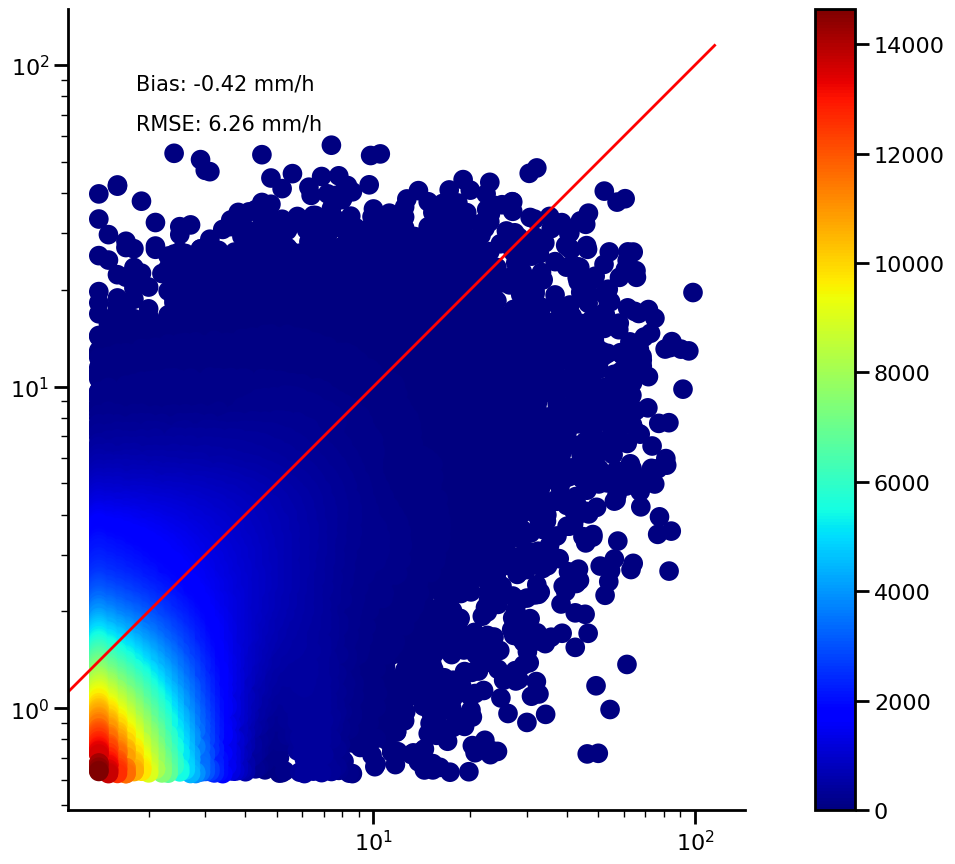

In [17]:
# since most of the regions had no rain, so we need to exclude those regions.
# Otherwise, it will inflate our stats

df= df[df.mrms>.1]


fig, ax= scatter(df.mrms.values, df.imerg.values, s=1)
bias= (df.imerg - df.mrms).mean()
rmse= np.sqrt(((df.imerg - df.mrms)**2).mean())
ax.text(0.1,0.9, 'Bias: %.2f mm/h'%bias, transform=ax.transAxes)
ax.text(0.1,0.85, 'RMSE: %.2f mm/h'%rmse, transform=ax.transAxes)


# Exercise

Now it is your turn to practice. Please copy and paste codes in the above and change datetime and study region to whatever event you are interested in.

After you're done with it, you can share your results with others.